In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from skimage.feature import peak_local_max

In [2]:
def show(image, figsize=(6,6)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(image, 'gray')

#### 0. Image loading.

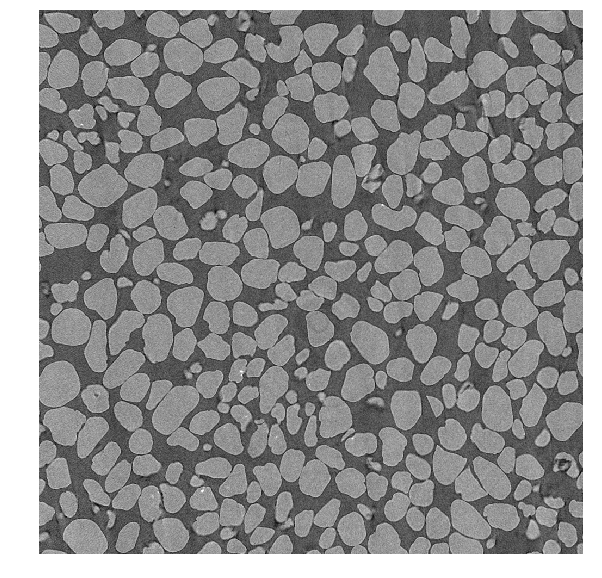

In [3]:
grayscale = cv.imread('./0.png', 0)
img = cv.imread('./0.png')

show(img,(10,10))

#### 1. Edge enhancement with unsharp mask.

In [4]:
def unsharp_mask(image, kernel_size=(5,5), sigma=1.0, amount=1.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    # For details on unsharp masking, see:
    # https://en.wikipedia.org/wiki/Unsharp_masking
    # https://homepages.inf.ed.ac.uk/rbf/HIPR2/unsharp.htm
    blurred = cv.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

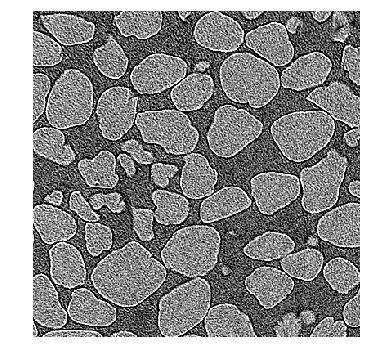

In [5]:
unsharp = unsharp_mask(grayscale, amount=6, threshold=0)

show(unsharp[:400,:400])

#### 2. Otsu's thresholding with bilateral blur.

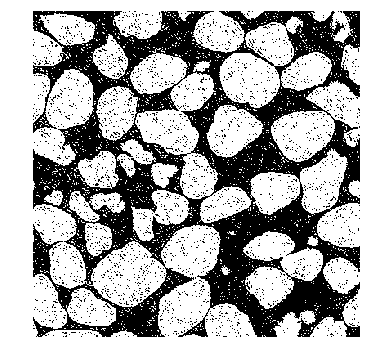

In [6]:
bilateral_blur = cv.bilateralFilter(unsharp, 9, 75, 75)
ret, th = cv.threshold(bilateral_blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

show(th[:400,:400])

#### 3. Noise reduction.

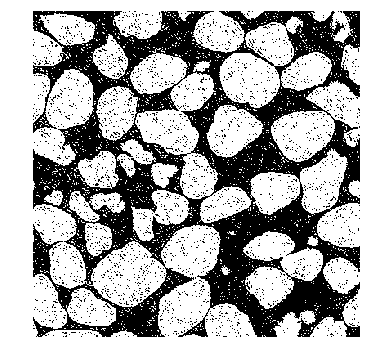

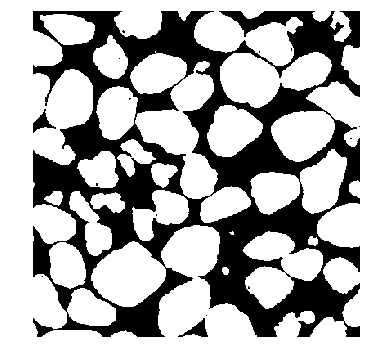

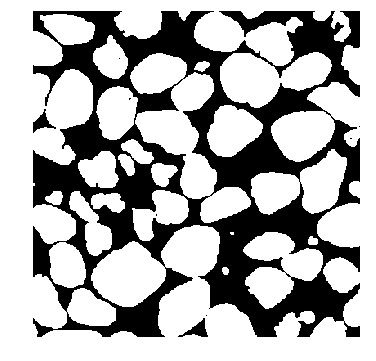

In [7]:
kernel = np.ones((3,3), np.uint8)  # TODO: Try another kernel? 

m_blur = cv.medianBlur(th, 3)
m_blur = cv.medianBlur(m_blur, 3)
opening = cv.morphologyEx(m_blur, cv.MORPH_OPEN, kernel, iterations = 1)

show(th[:400,:400])
show(m_blur[:400,:400])
show(opening[:400,:400])


#### 4. Watershed segmentation of touching particles.

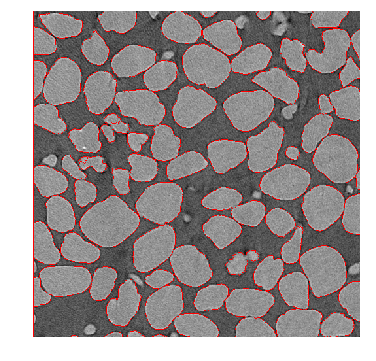

In [8]:
kernel = np.ones((3,3), np.uint8)  # TODO: Try another kernel? 

# sure background area
sure_bg = cv.dilate(opening, kernel, iterations=2)

# foreground area
dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 0)
dist_transform = cv.normalize(dist_transform, dist_transform, 0, 255, cv.NORM_MINMAX)
ret, sure_fg = cv.threshold(dist_transform, 0.22 * dist_transform.max(), 255, 0)
#sure_fg = peak_local_max(dist_transform, threshold_rel = 0, indices=False, min_distance=15, exclude_border=False)
                         #labels = opening, num_peaks_per_label=1)

# unknown region
sure_fg = sure_fg * 100000
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1
markers[unknown==255] = 0

markers = cv.watershed(img, markers)
borders = np.zeros(markers.shape)
borders[markers == -1] = 255

img[markers == -1] = [255, 0, 0]
show(img[:500,:500])

True

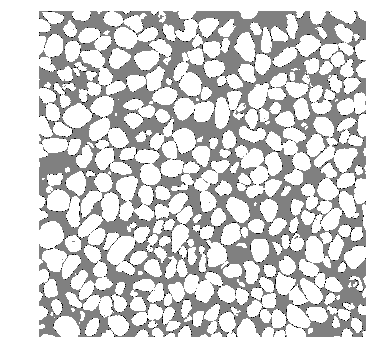

In [17]:
bordered = opening - borders
show(bordered)
cv.imwrite('./results/bordered.png', bordered)

#### 5. Contour detection.

In [18]:
bordered = cv.convertScaleAbs(bordered)
bordered = cv.erode(bordered, kernel, iterations=1) #  Сделать в другом месте, т.к. вызывается каждый раз.

Количество контуров (из 358):  403


True

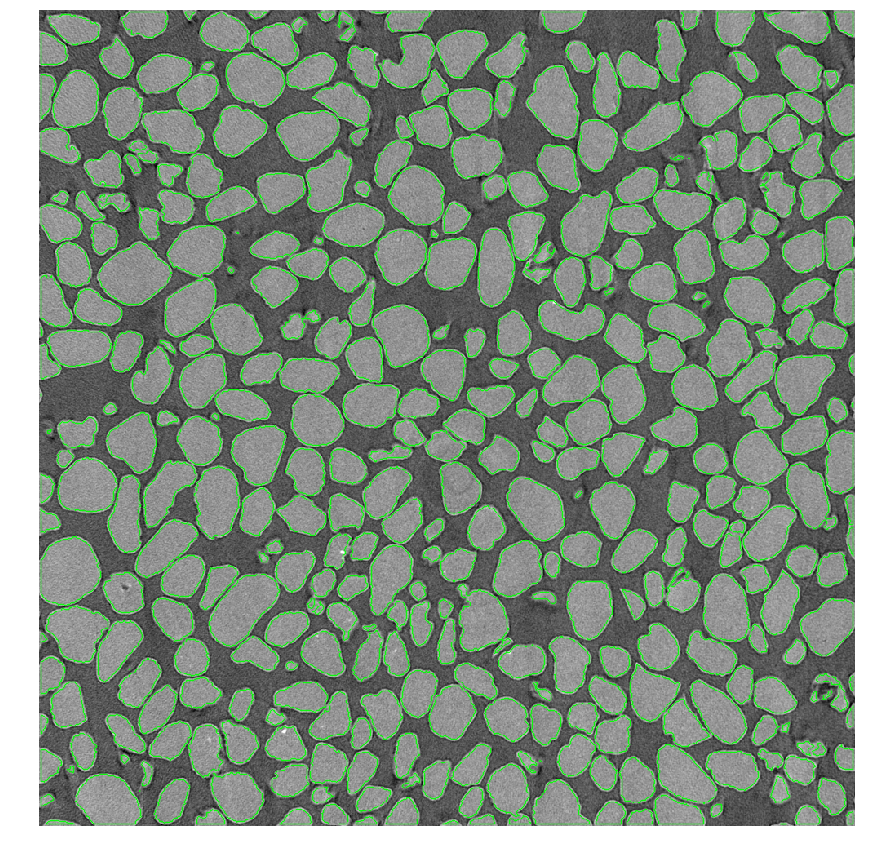

In [37]:
contours, hierarchy = cv.findContours(bordered, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

result = cv.cvtColor(grayscale, cv.COLOR_GRAY2RGB)
cv.drawContours(result, contours, -1, (0,255,0), thickness=1, lineType=cv.LINE_AA)

print('Количество контуров (из 358): ', len(contours))
show(result, (15,15))
cv.imwrite('./results/contours.png', result)

In [83]:
result = cv.cvtColor(grayscale, cv.COLOR_GRAY2RGB)

for i, contour in enumerate(contours[320:330]):
    cv.drawContours(result, [contour], -1, (0,255,0), thickness=1, lineType=cv.LINE_AA)
    cv.imwrite('./results/contours/{}.png'.format(i), result)

In [16]:
cv.imwrite('./results/opening.png', opening)
cv.imwrite('./results/sure_bg.png', sure_bg)
cv.imwrite('./results/sure_fg.png', sure_fg)
cv.imwrite('./results/unknown.png', unknown)
cv.imwrite('./results/dist_transform.png', dist_transform)
cv.imwrite('./results/result.png', img)
cv.imwrite('./results/markers.png', markers)

True

TODO:
    Use local_peak_finding to find small particles.
    Combine that with first method.